In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from scipy import special
from scipy import stats
sns.set(rc={'figure.figsize' : (12, 5)}, font='verdana')
plt.style.use('dark_background')

### 2
[ВТОРОЕ ИСПРАВЛЕНИЕ - ЗДЕСЬ ](#1)


Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [111]:
url='https://drive.google.com/file/d/18Fa0cDVGq7bf8O7KEb23CFgU0w5qsMaD/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_r = pd.read_csv(url, sep=";")
df_r

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [112]:
url='https://drive.usercontent.google.com/download?id=12xLu8LW-RvixxIPkourv73x4IUbqpYow&export=download&authuser=0&confirm=t&uuid=d43e5d1c-cec3-4518-84ae-d49b30d9c527&at=AENtkXYRTcBqWPAkd3eLSmLq1DSN%3A1733307676786'
df_a = pd.read_csv(url, sep=";")
df_a

KeyboardInterrupt: 

Подготовка и знакомство с данными

In [51]:
#Таймстэмпы оказались импортированы как целые числа, переведем их даты и переименуем колонки в привычные, простые и запоминающиеся

df_r.reg_ts = pd.to_datetime(df_r.reg_ts, unit='s')
df_r = df_r.rename(columns = {'reg_ts' : 'r_date',
                     'uid' : 'id'})
df_a.auth_ts = pd.to_datetime(df_a.auth_ts, unit='s')
df_a = df_a.rename(columns = {'auth_ts' : 'a_date',
                     'uid' : 'id'})

In [53]:
df_r.id.nunique() == len (df_r)

True

В регистрациях у нас только уникальные id

In [54]:
print(f' в авторизациях у нас {df_a.id.nunique()} уникальных id в {len(df_a)} авторизациях')

 в авторизациях у нас 1000000 уникальных id в 9601013 авторизациях


Все зарегистрированные id авторизовались хотя бы 1 раз

Соберем два набора данных в один по id - допишем в каждую авторизацию дату регистрации этого id.

In [55]:
df = pd.merge(df_a, df_r, how = 'left', on='id')

Посмотрим на данные

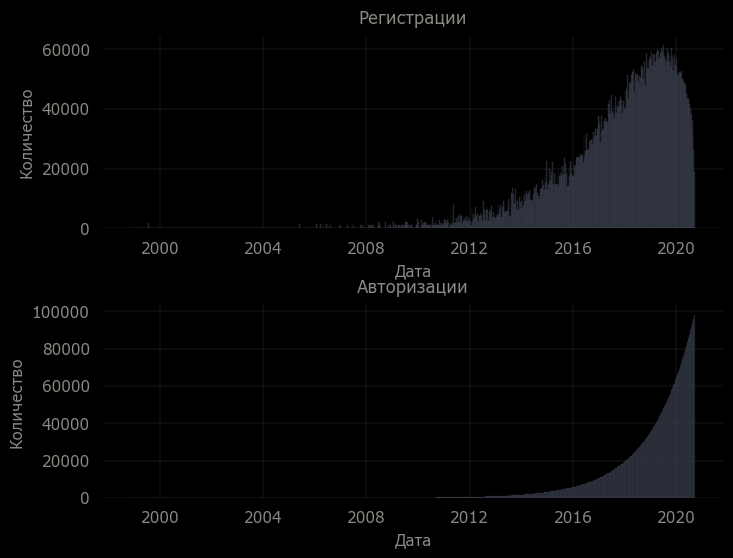

In [56]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)
plt.subplot(2, 1, 1)
sns.histplot(df.r_date, color='#171e2f')
plt.title('Регистрации', fontsize=12, y=1.02, color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df.a_date, color='#171e2f')
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('Авторизации', fontsize=12, y=1.02,color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)

plt.show()

Данные выглядят оборванными, а авторизации - искусственно созданными. Давайте поковыряем распределение числа авторизаций по дням

In [57]:
df_tmp = df.a_date.dt.date.value_counts().sort_index().reset_index()
df_tmp.columns = ['a_date','cnt']
df_tmp.head(1)

,a_date,cnt
0,1998-11-18,1


График авторизаций сильно похож на экспоненту, что если это она и есть?

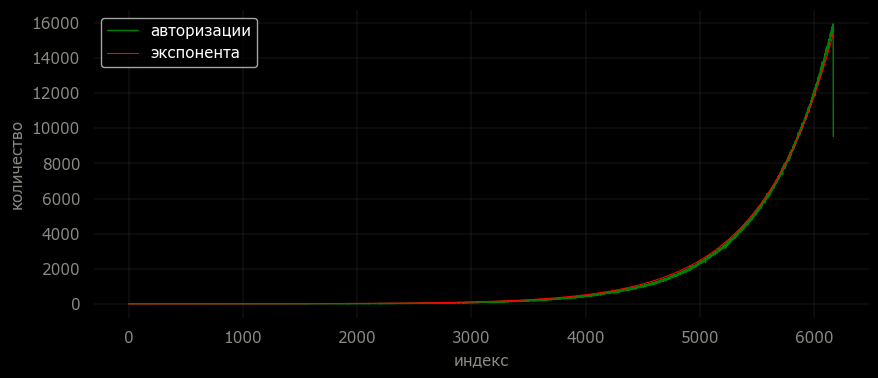

In [58]:
plt.figure(figsize=(10,4))
sns.lineplot(x = df_tmp.index, y = df_tmp.cnt, color='green',linewidth=1, label='авторизации')

tmp = pd.Series([1.001564**x for x in range(1, 6169)])

sns.lineplot(x = tmp.index, y = tmp.values, linewidth=0.8, color = ('red'), label='экспонента')
plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("индекс", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("количество", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)

plt.show()

График функции 1.001564**x поразительно совпадает с распределеним авторизаций. Что касается оборванности, то либо приложение вырубили - и с 24 сентября уже нельзя было ни авторизоваться ни зарегистрироваться, либо данные неполные, либо для этой задачи взяли или сгенерировали произвольный набор данных. Посмотрим на основные метрики набора данных.

In [59]:
df_tmp=df.groupby('id').a_date.count().sort_values(ascending = False)
print(f'\
1. Временной интервал набора данных:    начало:  {df['r_date'].min()} \n\
                                        конец:   {df['r_date'].max()} \n\
2. Уникальных пользователей:                     {df_r.id.nunique()} \n\
3. Зарегистрировались, но в игру так и не зашли: {pd.merge(df_r, df_a, how='left', on='id').a_date.isna().sum()}\n\
4. Зашли в игру один раз                         {df_tmp[df_tmp.values == 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values == 1].count()/len(df_r), 1)}%) \n\
5. Зашли в игру больше одного раза:              {df_tmp[df_tmp.values > 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values > 1].count()/len(df_r), 1)}%) \n\
6. NaN в наборе данных                           {df.isna().a_date.sum()+df.isna().r_date.sum()+df.isna().id.sum()} \n\
')


1. Временной интервал набора данных:    начало:  1998-11-18 09:43:43 
                                        конец:   2020-09-23 15:17:24 
2. Уникальных пользователей:                     1000000 
3. Зарегистрировались, но в игру так и не зашли: 0
4. Зашли в игру один раз                         761622 пользователей  (76.2%) 
5. Зашли в игру больше одного раза:              238378 пользователей  (23.8%) 
6. NaN в наборе данных                           0 



Проверим, совпадает ли первая авторизация с регистрацией

In [60]:
df_check = df.groupby('id', as_index = False).agg({'a_date': 'min', 'r_date': 'min'})
df_check['check'] = df_check.a_date == df_check.r_date
df_check.check.value_counts()

check
True    1000000
Name: count, dtype: int64

Совпадает для всех пользователей

Вернемся к изначальным данным и retention игроков "по дням от даты регистрации игрока". То есть, нас интресует возврат игроков, зарегистрировавшихся в определенный день, в игру в течение определенного временного интервала в днях. А значит в функции будет два аргумента: 

- День регистрации - reg_day

- Число дней на возврат в игру - days_to_get_back

- Источник данных (для разных целей можно предварительно готовить его различными способами)

In [61]:
def rtn(reg_day, days_to_be_back, df_rgd):
    
    # Готовим дату если нужно - зависит от способа дальнейшего использования функции
    # reg_day = datetime.strptime(reg_day, '%Y-%m-%d')

    #Вырезаем нужный интервал из источника данных, чтобы не крутить лишний объем данных
    df_tmp = df_rgd[(df_rgd.r_date >= reg_day) & (df_rgd.r_date <= reg_day + timedelta(days = days_to_be_back))].copy()

    # Собираем пользователей, зарегистрировавшихся в указанный день
    df_tmp.r_date = df_tmp.r_date.dt.date
    df_tmp.r_date = pd.to_datetime(df_tmp.r_date)
    rgd_users     = df_tmp[df_tmp.r_date == np.datetime64(reg_day.date())]\
                          .groupby('id',as_index = False)\
                          .agg({'r_date':'nunique'})\
                          .id
    coh_cnt       = rgd_users.count()

    # Считаем последний день диапазона для возврата
    last_day      = reg_day + timedelta(days = days_to_be_back)

    # Считаем активных пользователей за период из числа зарегистрировавшихся в указанный день
    df_active     = df_tmp[(df_tmp.a_date > reg_day) & (df_tmp.a_date <= last_day) & (df_tmp.id.isin(rgd_users))]\
                          .groupby('id', as_index = False)\
                          .agg({'r_date':'count'})
    active_users  = df_active[df_active.r_date > 1].r_date.count()
    return [reg_day.date(), days_to_be_back, round(active_users / coh_cnt, 3)]

Итак, у нас есть функция, которой на вход подается дата регистрации, временной итервал в днях и датафрейм - источник данных.
Функция считает, какое количество пользователей, зарегистрировавшихся в поданную дату - заходили повторно за поданный промежуток времени.

Теперь мы можем ее использовать как для одиночного вычисления, так и для сбора данных по конкретным датам. Например, так

In [62]:
# АХТУНГ - 5 минут считается на моем компе

t = pd.DataFrame({'reg_date': [1], 'retention' : [3]})
for i in range(1,3676):
    r = pd.Series(rtn(datetime.strptime('2010-09-01', '%Y-%m-%d') + timedelta(days = i), 10, df))
    r1 = pd.DataFrame({'reg_date': [r[0]], 'retention' : [r[2]]})
    t = pd.concat([t, r1], axis = 0 ).reset_index(drop = True)
t = t.drop(index = 0, axis = 1)
t.reg_date = pd.to_datetime(t.reg_date)

За 10 лет для каждой дневной когорты мы посчитали десятидневный retention и собрали в массив. Теперь можно посмотреть на график.

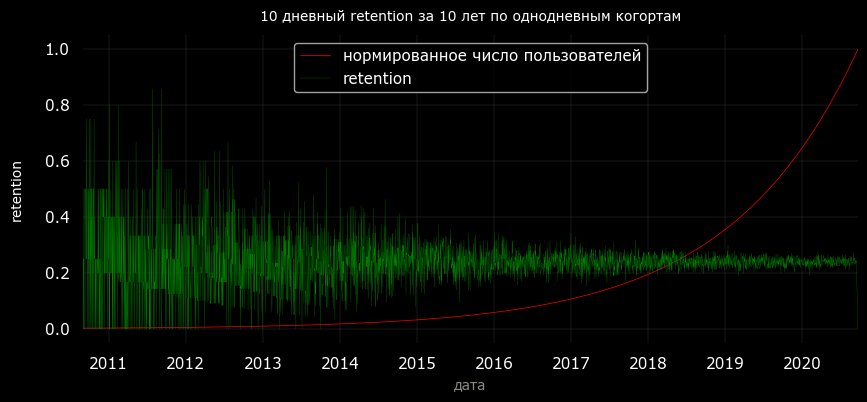

In [63]:
df_cnt = df.groupby('id').r_date.min().to_frame().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x = df_cnt.r_date, y = df_cnt.index/1000000, linewidth=0.5, color='red', label='нормированное число пользователей')
sns.lineplot(x = t.reg_date, y = t.retention, linewidth=0.2, color='green', label='retention')
plt.title('10 дневный retention за 10 лет по однодневным когортам', fontsize=10, y=1.02)
plt.xlim(datetime.strptime('2010-09-01', '%Y-%m-%d'), datetime.strptime('2020-09-23', '%Y-%m-%d'))
plt.xlabel("дата", labelpad = 5, fontsize= 10,color='#8b8a84')
plt.ylabel('retention', labelpad = 15, fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 
plt.show()

Артефакты на графике снова наводят на мысль об искусственном происхождении данных, как будто что-то нарисовади, но будем и дальше ковырять что дали и интерпретировать график как-будто это реальные данные.

Видим, что на начальных этапах пользователями являлся узкий круг разработчиков, тестировщиков, энтузиастов сообщество раширялось скачкообразно по мере нововедений, которые сразу же проверялись - и ретеншн подскакивал почти до 100%. Но по мере роста числа обычных польхователей начало проявлятся истинное распределение и его среднее.

Но теперь мы можем с помощью функции посмотреть не только историю определенного retention дневных когорт. Мы можем посмотреть и распределение retention разной периодичности для определенных когорт

In [64]:
tt = pd.DataFrame({'reg date': [1], 'days_shift' : [2], 'retention' : [3]})
for i in range(30):
    rr = pd.Series(rtn(datetime.strptime('2018-04-09', '%Y-%m-%d'), 1+i, df))
    rr1 = pd.DataFrame({'reg date': [rr[0]], 'days_shift' : [rr[1]], 'retention' : [rr[2]]})
    tt = pd.concat([tt, rr1], axis = 0 ).reset_index(drop = True)
tt = tt.drop(index = 0, axis = 1)

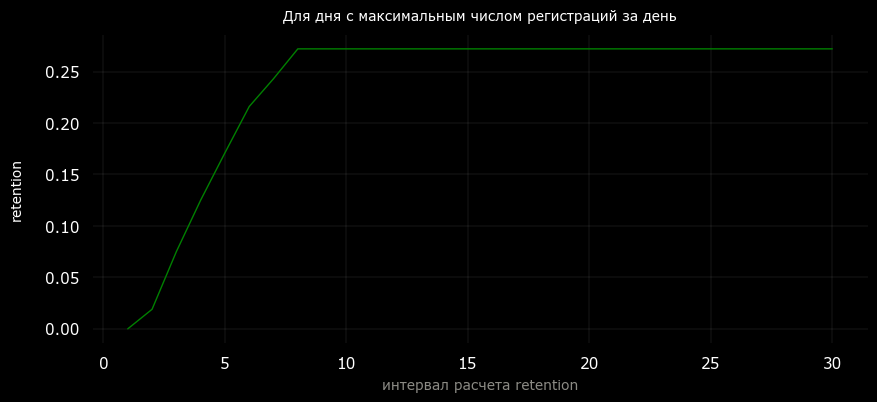

In [65]:
plt.figure(figsize=(10,4))
sns.lineplot(x = tt.days_shift, y = tt.retention, linewidth=1, color='green')
plt.title('Для дня с максимальным числом регистраций за день', fontsize=10, y=1.02)
plt.xlabel("интервал расчета retention", labelpad = 5, fontsize= 10,color='#8b8a84')
plt.ylabel('retention', labelpad = 15, fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 
plt.show()

Как-будто, если пользователь не зашел повторно за 10 дней - то он скорее всего уже не зайдет никогда

In [66]:
days_to_get_back = df[df.r_date != df.a_date].groupby('id', as_index = False).agg({'a_date':'min'})
df_back = pd.merge(df_r, days_to_get_back, how = 'left', on='id')
df_back['days'] = (df_back.a_date - df_back.r_date).dt.floor('D')
df_back.days.value_counts(dropna=False)

days
NaT       761622
1 days     40202
2 days     39955
3 days     39732
4 days     39605
6 days     39577
5 days     39306
7 days         1
Name: count, dtype: int64

Это довольно странно - пользователи забывают про игру через 7 дней. За двадцать лет никто не зашел в приложение через неделю. При этом остальные пользователи поделились почти одинаково по группам

 -----------------------

Работа над первым замечанием.

Замечание: 

***Это довольно странно - пользователи забывают про игру через 7 дней. За двадцать лет никто не зашел в приложение через неделю*** 

Это не так. Есть много пользователей, которые возвращались в приложение спустя месяц и более, в этом нетрудно убедиться прямой проверкой по конкретным id. На самом деле, общая картина здесь примерно такова: ежедневный retention достигает пика где-то на 6-7 день после регистрации, а затем в течение нескольких недель медленно спадает почти до нуля. 

***Присмотрись внимательно к коду***, ты что-то упускаешь.

Посмотрим на источник данных еще раз

In [67]:
df.sort_values(['id', 'a_date'])

,a_date,id,r_date
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09
...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31


Для каждого пользователя определяем дату и время второй авторизации

In [68]:
days_to_get_back = df[df.r_date != df.a_date].groupby('id', as_index = False).agg({'a_date':'min'})
days_to_get_back.head(3)

,id,a_date
0,2,1999-07-25 16:46:46
1,15,2002-05-10 04:20:54
2,18,2002-07-20 18:57:04


Каждому пользователю дописываем дату и время повторной авторизации

In [69]:
df_back = pd.merge(df_r, days_to_get_back, how = 'left', on='id')

Для каждого пользователя считаем разницу междй датой второй авторизации и датой регистрации в днях

In [70]:
df_back['days'] = (df_back.a_date - df_back.r_date).dt.floor('D')
df_back.sort_values(['id', 'a_date'])

,r_date,id,a_date,days
0,1998-11-18 09:43:43,1,NaT,NaT
1,1999-07-22 22:38:09,2,1999-07-25 16:46:46,2 days
2,2000-01-13 22:27:27,3,NaT,NaT
3,2000-05-28 14:19:01,4,NaT,NaT
4,2000-09-16 11:21:53,5,NaT,NaT
...,...,...,...,...
999995,2020-09-23 15:13:54,1110618,NaT,NaT
999996,2020-09-23 15:14:46,1110619,NaT,NaT
999997,2020-09-23 15:15:39,1110620,NaT,NaT
999998,2020-09-23 15:16:31,1110621,NaT,NaT


Посмотрим через сколько дней возвращались пользователи

In [71]:
df_back.days.value_counts(dropna = False)

days
NaT       761622
1 days     40202
2 days     39955
3 days     39732
4 days     39605
6 days     39577
5 days     39306
7 days         1
Name: count, dtype: int64

Проверим целостность данных

In [72]:
df_back.days.value_counts(dropna = False).values.sum() == len(df_back)

np.True_

Ничего не потеряно, все данные учтены, число строк в агрегации и источнике совпадает

In [73]:
df_back.days.sort_values(ascending = False).head(3)

28610    7 days
780053   6 days
865780   6 days
Name: days, dtype: timedelta64[ns]

Как видим, в данных нет пользователей, чья ***вторая*** авторизация случилась бы позже чем через 7 дней. Возвращаясь в изначальной формулировке 

"Это довольно странно - пользователи забывают про игру через 7 дней. За двадцать лет никто не зашел в приложение через неделю"

следует безусловно признать ее некорректной

Я имел ввиду, что если пользователь не зашел в игру ***повторно*** в течение недели - он уже не заходил в нее никогда. Это не означает, что после второго раза он не мог зайти третий, четвертый и т.д.

Будучи погруженным в контекст расчетов я неверно сформулировал вывод, подразумевая, что из контекста следует правильное толкование, но это безусловно не так.


-------------------

А еще можно собрать табличку по дням за некоторый период с динамикой изменения retention в зависимости от ширины временного интервала

In [74]:
table = pd.DataFrame({'reg_date': [1], '2 day' : [3], '3 day' : [3], '4 day' : [3], '5 day' : [3], '6 day' : [3], '7 day' : [3], '8 day' : [3], '9 day' : [3]})

for i in range(1,10):
    res = []
    for n in range(2,10):
        table_r = pd.Series(rtn(datetime.strptime('2018-04-09', '%Y-%m-%d') + timedelta(days = i), n, df))
        res.append([table_r[2]])
    table_r1 = pd.DataFrame({'2 day' : res[0], '3 day' : res[1], '4 day' : res[2], '5 day' : res[3], '6 day' : res[4], '7 day' : res[5], '8 day' : res[6], '9 day' : res[7]})
    table = pd.concat([table, table_r1], axis = 0 ).reset_index(drop = True)
    table.reg_date[i] = table_r[0]

table = table.drop(index = 0, axis = 1)
#table.reg_date = pd.to_datetime(table.reg_date)
table

C:\Users\mail\AppData\Local\Temp\ipykernel_10816\3612937040.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  table.reg_date[i] = table_r[0]
C:\Users\mail\AppData\Local\Temp\ipykernel_10816\3612937040.py:10: FutureWarning: Setting an item

,reg_date,2 day,3 day,4 day,5 day,6 day,7 day,8 day,9 day
1,2018-04-10,0.013,0.059,0.106,0.138,0.176,0.213,0.231,0.231
2,2018-04-11,0.016,0.061,0.122,0.164,0.210,0.255,0.276,0.276
3,2018-04-12,0.008,0.050,0.080,0.114,0.143,0.172,0.202,0.202
4,2018-04-13,0.016,0.063,0.108,0.153,0.188,0.235,0.257,0.257
5,2018-04-14,0.018,0.042,0.095,0.127,0.169,0.203,0.211,0.211
6,2018-04-15,0.026,0.077,0.111,0.145,0.201,0.224,0.240,0.240
7,2018-04-16,0.034,0.063,0.095,0.121,0.171,0.205,0.224,0.224
8,2018-04-17,0.026,0.092,0.134,0.160,0.202,0.249,0.276,0.276
9,2018-04-18,0.018,0.068,0.094,0.144,0.160,0.223,0.241,0.241


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
url='https://drive.google.com/file/d/1ZnhQzDliRiOlrADRJV_ZTlxOqqsMo4sc/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url,sep = ';')

In [ ]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [3]:
df_a = df[df.testgroup == 'a']
df_a.head(1)

,user_id,revenue,testgroup
1,2,0,a


In [4]:
df_b = df[df.testgroup == 'b']
df_b.head(1)

,user_id,revenue,testgroup
0,1,0,b


Проверим все ли записи в обеих группах уникальны

In [7]:
(df_a.user_id.nunique() == len(df_a))*1 + (df_b.user_id.nunique() == len(df_b))*1

2

Посмотрим на общие метрики по группам

In [6]:
print(f'Группа А: \n\
Клиентов всего:       {len(df_a)}\n\
Заплативших клиентов: {len(df_a[df_a.revenue > 0])}    \n\
СR в оплату:          {round(len(df_a[df_a.revenue > 0]) / len(df_a), 4)} \n\
Средний чек:          {round(df_a[df_a.revenue > 0].revenue.sum() / len(df_a[df_a.revenue > 0]),1)} \n\
Самый большой заказ:  {df_a.revenue.max()}\n\
    ')

Группа А: 
Клиентов всего:       202103
Заплативших клиентов: 1928    
СR в оплату:          0.0095 
Средний чек:          2664.0 
Самый большой заказ:  37433
    


In [7]:
print(f'Группа B: \n\
Клиентов всего:       {len(df_b)}\n\
Заплативших клиентов: {len(df_b[df_b.revenue > 0])}    \n\
СR в оплату:          {round(len(df_b[df_b.revenue > 0]) / len(df_b), 4)} \n\
Средний чек:          {round(df_b[df_b.revenue > 0].revenue.sum() / len(df_b[df_b.revenue > 0]),1)} \n\
Самый большой заказ:  {df_b.revenue.max()}\n\
    ')

Группа B: 
Клиентов всего:       202667
Заплативших клиентов: 1805    
СR в оплату:          0.0089 
Средний чек:          3003.7 
Самый большой заказ:  4000
    


Разница в сумме максимального заказа впечатляет. Посмотрим на распределение заказов по сумме

<Figure size 1300x600 with 0 Axes>

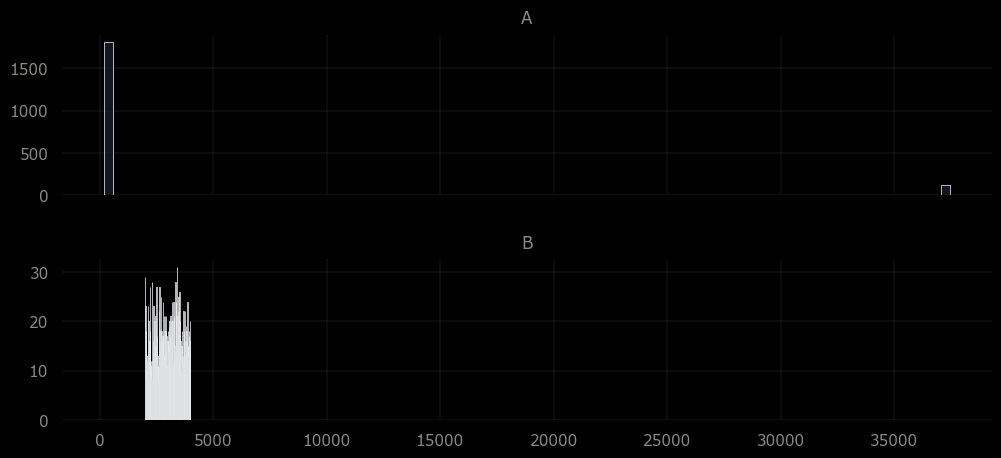

In [10]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Вот этот "пенечек" в группе А в районе 40000 (далее - "лакшери пенек") - makes a difference. Давайте посмотрим сколько в нем заказов

In [11]:
pd.cut(df_a[df_a.revenue > 0].revenue, bins = 5).value_counts()

revenue
(162.767, 7646.6]     1805
(29986.4, 37433.0]     123
(7646.6, 15093.2]        0
(15093.2, 22539.8]       0
(22539.8, 29986.4]       0
Name: count, dtype: int64

123 заказа в хвостовом лакшери пеньке

In [12]:
df_a.revenue.sort_values().tail(123)

19495     37293
254113    37294
34534     37294
235858    37294
81477     37294
          ...  
142804    37379
21585     37385
65077     37394
196601    37407
101861    37433
Name: revenue, Length: 123, dtype: int64

Все как на подбор

In [13]:
print(f'В группе А в бомжовом пеньке {df_a.revenue.sum() - 37300*123}, а в лакшери пеньке {37300*123} \n \
                    то есть {round(100*(df_a.revenue.sum() - 37300*123)/df_a.revenue.sum(),0)}% и                    {round(100*(37300*123)/df_a.revenue.sum(),0)}%  соответственно')

В группе А в бомжовом пеньке 548289, а в лакшери пеньке 4587900 
                     то есть 11.0% и                    89.0%  соответственно


Как видим в групрпе А все деньги в лакшери пеньке. Вот бы узнать как получилось, что 1800 клиентов сделали заказы от 2000 до 4000, а 123 - по 37000 зарядили. Что это за акционное предложение такое? 

Заставь 12 друзей купить у нас по настолке и получи скидку 50% на плазменную панель?

Короче, во-первых, состояние группы А вызывает вопросы. Как-будто бомжовый и лакшери пеньки гистограммы связаны между собой каким-то принудительным механизмом.

- Толи неправильно подготовили данные и в розницу попали оптовики, но уж больно суммы больших заказов совпадают

- Из-за близости сумм больших заказов можно подумать, что и в самом деле какой-то товар продается по акции, но суммы все же разнятся. Из-за курса ежедневно ценники меняют? Ну так вроде е 90-е же

- А может параллельно ликвидацию телевизоров с повреждегной упаковкой начальство провело и сотрудники все разобрали, чтобы через авито потом обналичить?

- А может смысл группы А был в том чтобы избавиться от дорогого неликвида и дело вобщене в деньгах, а в обналичивания мертвого складского остатка пусть и с потерями, но зато с живыми деньгами

Загадки во тьме.

А, во-вторых, среднее группы А не отражает вообще ничего...

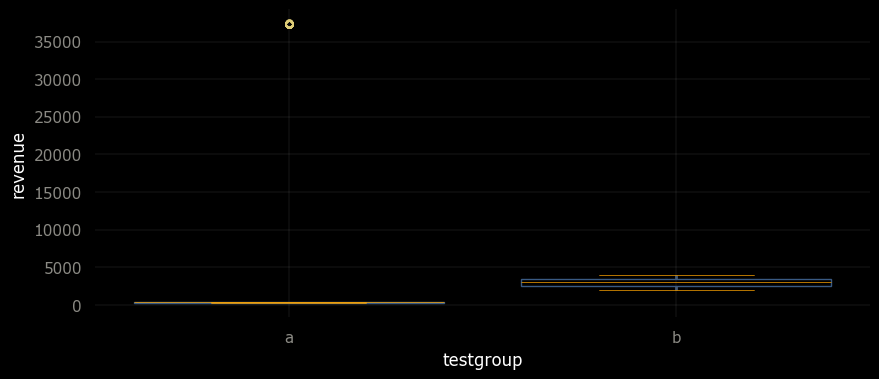

In [14]:
plt.figure(figsize=(10,4))
boxplot_style = {
    'medianprops':  {'linewidth': 4, 'color': '#571a18'},
    'flierprops':   {'marker': 'o', 'markerfacecolor': 'green', 'markersize': 8},
    'boxprops':     {'facecolor': 'none', 'edgecolor ': '#435975', 'linewidth': 1},
    'capprops':     {'color': 'orange', 'linewidth': 1}}
sns.boxplot(x = df[df.revenue>0].testgroup, y = df[df.revenue>0].revenue, 
                                                            whiskerprops = {'linewidth': 2, 'color': '#435975'},
                                                            medianprops  = {'linewidth': 4, 'color': 'orange', 'linewidth': 0.5},
                                                            flierprops   = {'marker': 'o', 'markeredgecolor': '#e0ce79', 'markersize': 5, 'markerfacecolor' :'none', 'linewidth': 0.1},
                                                            boxprops     = {'facecolor': 'none', 'edgecolor': '#395a83', 'linewidth': 1},
                                                            capprops     = {'color': 'orange', 'linewidth': 0.5})
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

Как видим, медианы различаются драматически...

In [15]:
df[(df.revenue>0) & (df.testgroup == 'a')].revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [16]:
df[(df.revenue>0) & (df.testgroup == 'b')].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

... ну да - в 10 раз, то есть, на порядок медиана группы В превышает медиану группы А. 

С точки зрения ответа на изначальный вопрос "Какой набор предложений можно считать лучшим?" все упирается в изучение природы лакшери пенька. Он слишком маленький по числу заказов для того, чтобы уверенно считать его системным фактороми и одновременно слишком большой по деньгам для того, чтобы исключать его из рассмотрения.

При этом если в лакшери пеньком экономики А и В примерно сходятся, то без него группа А просто исчезает.


In [17]:
df[(df.revenue>0) & (df.revenue < 37000) & (df.testgroup == 'a')].revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [18]:
print(f'выручка группы А с лакшери пеньком                                    {df[(df.revenue>0) & (df.testgroup == 'a')].revenue.sum()} \n\
потеря всего 1 заказа из лакшери пенька уменьшает выручку группы А на 37000 или {round(100*37000/df[(df.revenue>0) & (df.testgroup == 'a')].revenue.sum(),1)}% \n\
выручка группы А без лакшери пенька                                   {df[(df.revenue>0) & (df.revenue < 37000) & (df.testgroup == 'a')].revenue.sum()} \n\
выручка группы B                                                      {df[(df.revenue>0) & (df.testgroup == 'b')].revenue.sum()} ')

выручка группы А с лакшери пеньком                                    5136189 
потеря всего 1 заказа из лакшери пенька уменьшает выручку группы А на 37000 или 0.7% 
выручка группы А без лакшери пенька                                   545937 
выручка группы B                                                      5421603 


Без лакшери пенька группа А - 10% от группы В.

Заявлено, что группа В - тестовая, группа А - контрольная. То есть, группа А - это как все есть на сейчас, а В - это вариант, который тестируется.

И если лакшери пенек - системная часть группы А, то тот факт что она не перешла в группу В ни в каком виде - ставит под вопрос дизайн эксперимента, как так получилось, что ключевая часть дохода не наследуется.

При этом даже без этой части группа В соразмерна по результатам с группой А, предлагая стабильно более высокое среднее.


Вывод: Для принятия окончательного решения следует понять природу лакшени пенька группы А и в новом эксперименте постараться учесть возможность наследования лакшери пенька и сохранения десятикратного роста среднего чека по основное массе заказов гурппы В. 

На данном же этапе группа В выглядит как более стабильная, предсказуемая и понятным образом масштабируемая

-----------------

*** Работа над вторым замечанием ***

Замечание:

Наличие резко выделяющихся 123 значений в контрольной группе действительно вызывает  вопросы, и ответа на них у нас нет и не предвидится, к сожалению. Видимо, придется работать с тем, что есть, и считать эти нетипичные продажи легитимной частью данных — без них основные метрики различаются на сотни процентов, как ты заметил, и анализировать становится почти нечего. 

В любом случае, анализ надо довести до конца, хотя бы формально. А для этого потребуется статистика, и итоговый вывод должен опираться на нее, а не на общие рассуждения.


Итак, рассмотрим наши группы вновь

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

<Figure size 1300x600 with 0 Axes>

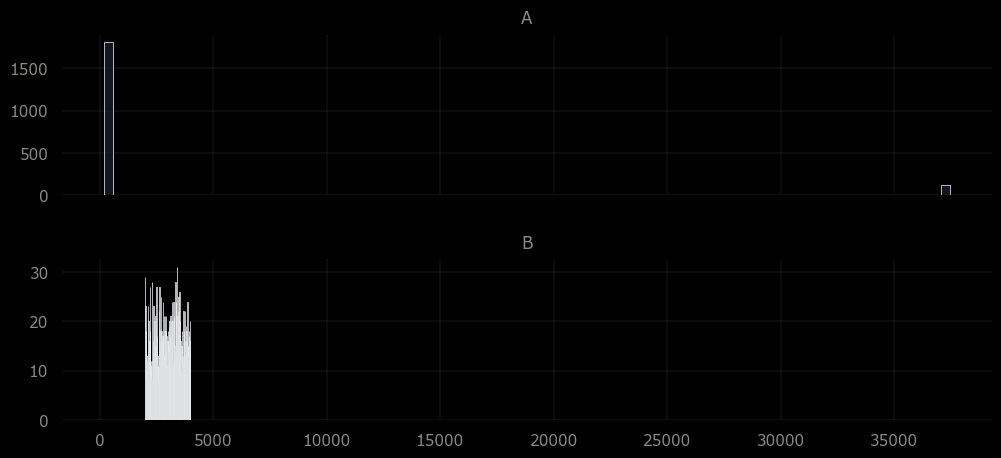

In [19]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Очевидно, что оба распределения не являются нормальными

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

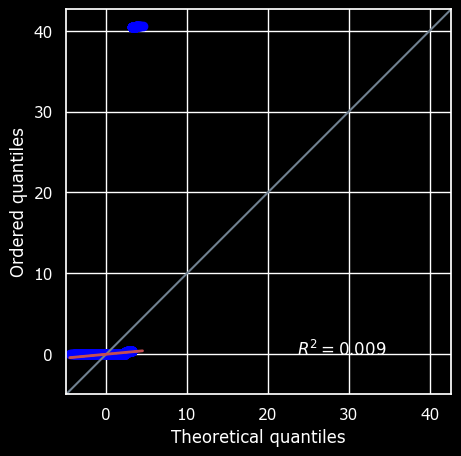

In [20]:
pg.qqplot(df_a.revenue)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

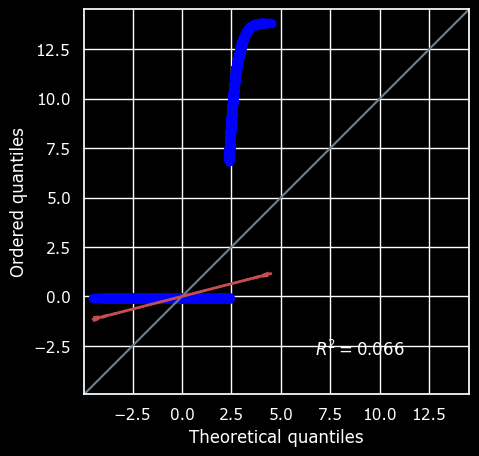

In [21]:
pg.qqplot(df_b.revenue)

Кроме того, средние нам ни о чем не говорят в данном случае. А значит нас интересуют медианы.

In [22]:
print(f'медиана группы А                                   {df_a[df_a.revenue>0].revenue.median()} \n\
медиана группы B                                   {df_b[df_b.revenue>0].revenue.median()} ')

медиана группы А                                   311.0 
медиана группы B                                   3022.0 


Постараемся понять могут ли эти медианы принадлежать одному распределению. Для это прибегнем к bootstrap

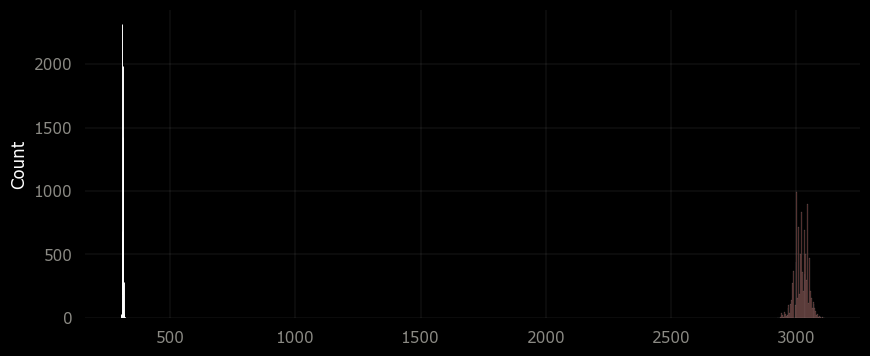

In [23]:
t_a = pd.Series([df_a[df_a.revenue>0].revenue.sample(frac=1, replace = True).median() for _ in range(10000)])
t_b = pd.Series([df_b[df_b.revenue>0].revenue.sample(frac=1, replace = True).median() for _ in range(10000)])

plt.figure(figsize=(10,4))
plt.tick_params(axis='both', colors='#8b8a84')
sns.histplot(t_a, color='#171e2f')
sns.histplot(t_b, color='#592927')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)


Как видим, пересечение распеределений медиан практически невероятно. То есть, медиана группы В закономерно больше и эти различия статистически значимы

In [30]:
print(f'Группа А: \n\
Клиентов всего:       {len(df_a)}\n\
Заплативших клиентов: {len(df_a[df_a.revenue > 0])}    \n\
СR в оплату:          {round(len(df_a[df_a.revenue > 0]) / len(df_a), 4)} \n\
Выручка группа А:     {round(df_a[df_a.revenue > 0].revenue.sum())} \n\
Средний чек:          {round(df_a[df_a.revenue > 0].revenue.sum() / len(df_a[df_a.revenue > 0]),1)} \n\
Самый большой заказ:  {df_a.revenue.max()}\n\
    ')

Группа А: 
Клиентов всего:       202103
Заплативших клиентов: 1928    
СR в оплату:          0.0095 
Выручка группа А:     5136189 
Средний чек:          2664.0 
Самый большой заказ:  37433
    


In [32]:
print(f'Группа B: \n\
Клиентов всего:       {len(df_b)}\n\
Заплативших клиентов: {len(df_b[df_b.revenue > 0])}    \n\
СR в оплату:          {round(len(df_b[df_b.revenue > 0]) / len(df_b), 4)} \n\
Выручка группа B:     {round(df_b[df_b.revenue > 0].revenue.sum())} \n\
Средний чек:          {round(df_b[df_b.revenue > 0].revenue.sum() / len(df_b[df_b.revenue > 0]),1)} \n\
Самый большой заказ:  {df_b.revenue.max()}\n\
    ')

Группа B: 
Клиентов всего:       202667
Заплативших клиентов: 1805    
СR в оплату:          0.0089 
Выручка группа B:     5421603 
Средний чек:          3003.7 
Самый большой заказ:  4000
    


Мы видим, что выручка и средний чек группы В выше даже при несколько меньшем CR в оплату, при этом разница результатов статистически значима.

То есть, приложив усилия по увеличению CR в тестовой группе B мы вправе расчитывать на еще большее увеличение среднего чека и выручки.

Таким образом, тестовую группу набора предложений мы можем признать лучшей.

<a id="1">Работа над ошибками 2 </a> 

Цитата: "Выбрать целевую метрику, или метрики, для анализа, проверить соответствующие гипотезы и сделать вывод по результатам этих проверок"

Выберем целевые метирики для нашего исследования. Нас интересует объем продаж покупателей и успешность конвертации посетителей в покупателей. То есть:

ARPPU - среднее этой метрики позволит понять сколько денег нам в среднем заносит каждый покупатель, чем выше этот показатель, тем лучше

CR в покупку - важно с точки зрения затрат на привлечение покупателя, чем больше трафика реализуется, то есть чем выше CR, тем лучше

Построим на распределения групп А и В

<Figure size 1300x600 with 0 Axes>

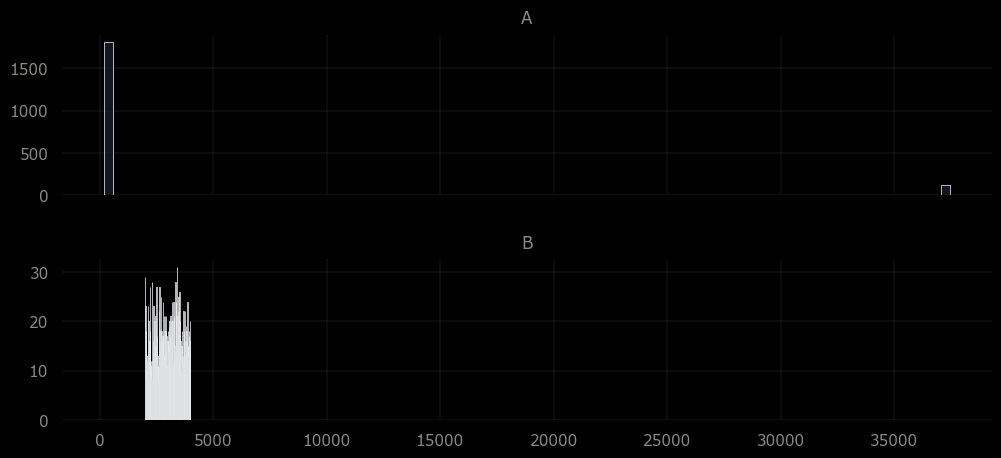

In [54]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

ARPPU = Число повторных покупок * Средний чек

In [52]:
print(f' В группе А нет повторных покупок:    {df_a[df_a.revenue > 0].user_id.nunique() == len(df_a[df_a.revenue > 0].user_id)} \n \
В группе В нет повторных покупок:    {df_b[df_b.revenue > 0].user_id.nunique() == len(df_b[df_b.revenue > 0].user_id)}')

 В группе А нет повторных покупок:    True 
 В группе В нет повторных покупок:    True


Чмсло повторных покупок для обеих групп равно 1 (видимо потому что речь идет об акционном наборе, который предлагается одному клиенту один раз), а значит ARPPU в нашем случае равен среднему чеку, то есть отношению всей выручки группы к числу покупок или иначе - среднему распределения выручки по заказам.

In [162]:
print(f'ARPPU контрольный групы А:    {round(df_a[df_a.revenue > 0].revenue.sum() / len(df_a[df_a.revenue > 0]),1)} \n\
ARPPU тестовой групы В:       {round(df_b[df_b.revenue > 0].revenue.sum() / len(df_b[df_b.revenue > 0]),1)} \n\
    ')

ARPPU контрольный групы А:    2664.0 
ARPPU тестовой групы В:       3003.7 
    


ARPPU тестовой группы В выше. Необходимо оценить статистическую значимость этого различия.

Нулевая гипотеза заключается в том, что ARPPU групп А и В не имеют статистически значимых различий.

Выберем тест для проверки нулевой гипотезы.

Распределение группы В очень похоже на равномерное распределение, которое хорошо сходится средними выборок к истинному среднему

<Figure size 1300x600 with 0 Axes>

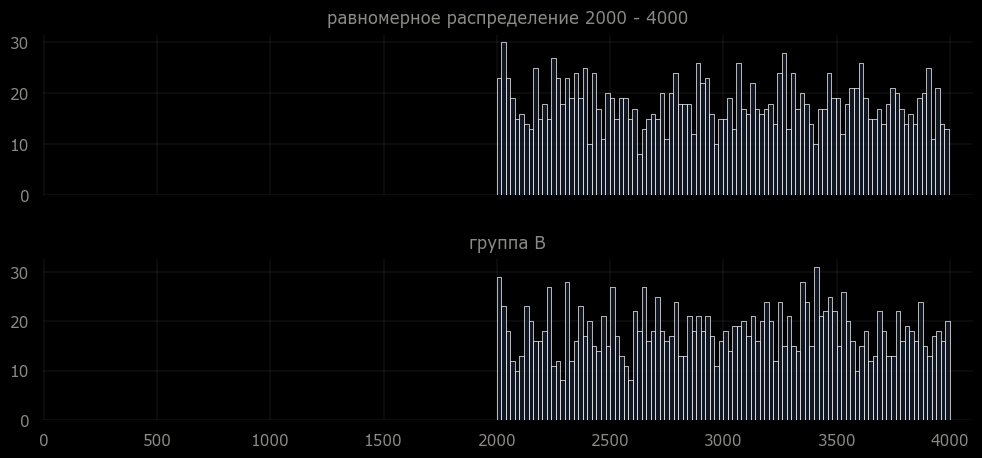

In [58]:
uni = np.random.uniform(2000, 4000, 1805)

plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(uni, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('равномерное распределение 2000 - 4000', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlim(-5, 4100)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('группа B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Посмотрим на распределение группы А: оно не нормальное, асимметричное и с огромным хвостом. 

Сначала я решил в качестве примера распределения с похожими свойствами рассмотреть логнормальное распределение и посмотреть какому логнормальному распределению могла бы принадлежать выборка со средней амплитудой в 37000. Для этого переберем распределения с параметром S с шагом в 0,1, сделав по 10000 выборок из каждого и посчитав среднюю аплитуду для каждого шага.

In [163]:
df_t = pd.DataFrame({'n': [1], 'r': [1]})

ex_mean = []
rng = []
for n in range(27, 32, 1):
    l = stats.lognorm(n/10)
    for i in range(10000):
        e = l.rvs(size = 1928)
        ex_mean.append((e.max() - e.min()))
    df_t1 = pd.DataFrame({'n': [n], 'r': [round(sum(ex_mean)/len(ex_mean))]})
    df_t = pd.concat([df_t, df_t1])
df_t

,n,r
0,1,1
0,27,18454
0,28,22576
0,29,28223
0,30,36492
0,31,46651


Как видим, мы могли бы получить в выборке из 1928 значений хвост такой длины (37000) в случае если s логнормального распределения было бы в районе 3,0.

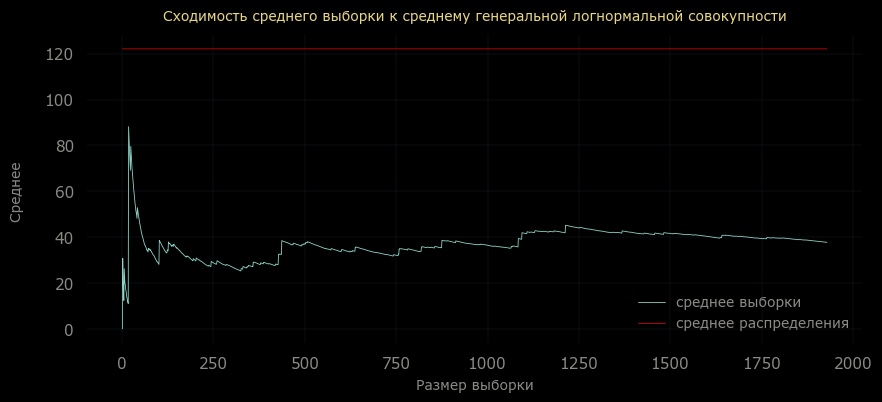

In [13]:
l_mean = l.stats(moments='m')

a = pd.Series(l.rvs(1928)).to_frame()
a.columns=['res']
a['csum']=a['res'].cumsum()
a['num']=range(1,1929)
a['cmean']=a.csum/a.num

plt.figure(figsize=(10,4))

sns.lineplot(x = a.num, y = a.cmean, linewidth=0.6, label = 'среднее выборки')
sns.lineplot(x = a.num, y = np.array([l_mean]*1928), linewidth=0.5, color = 'red', label = 'среднее распределения')

plt.legend(frameon=False, fontsize='small', labelcolor = '#8b8a84')
plt.title('Сходимость среднего выборки к среднему генеральной логнормальной совокупности', fontsize=10, y=1.02, color = '#e7d688')
plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("Размер выборки", labelpad = 5, color='#8b8a84', fontsize= 10)
plt.ylabel('Среднее ', labelpad = 15, color='#8b8a84', fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='#3f5b79', linestyle='-', linewidth=0.1) 
plt.show()

Но такое распределение не сходится к своему среднему с таким объемом выборки. И даже если увеличить выборку с 2000 до 100 000 и повторить эксперимент 100 раз, то получим следующуо картину

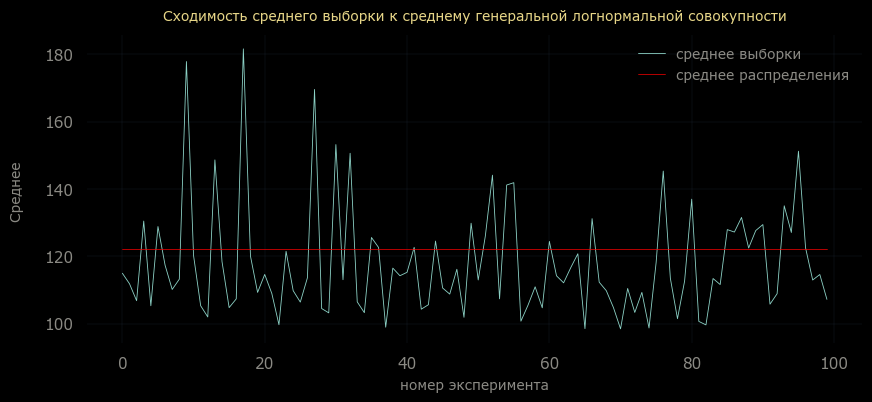

In [14]:
t = pd.Series([l.rvs(100000).mean() for n in range(1, 101)])

plt.figure(figsize=(10,4))

sns.lineplot(x = t.index, y = t.values, linewidth=0.6, label = 'среднее выборки')
sns.lineplot(x = t.index, y = np.array([l_mean]*100), linewidth=0.5, color = 'red', label = 'среднее распределения')

plt.legend(frameon=False, fontsize='small', labelcolor = '#8b8a84')
plt.title('Сходимость среднего выборки к среднему генеральной логнормальной совокупности', fontsize=10, y=1.02, color = '#e7d688')
plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("номер эксперимента", labelpad = 5, color='#8b8a84', fontsize= 10)
plt.ylabel('Среднее ', labelpad = 15, color='#8b8a84', fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='#3f5b79', linestyle='-', linewidth=0.1) 
plt.show()

И тут я подумал, что если при размере выборки в 100 000 срденее выборки очень плохо сходится к истинному среднему (а оно и понятно, каждое попавшее в выборку значение из хвоста сильно меняет ее среднее, образует новую ступеньку и среднее конкретной, отдельно взятой выборки определется лишь тем сколько значений из хвоста СЛУЧАЙНЫМ образом в нее попали), то любым тестом в данном случае мы сравниваем закономерность группы В со случайностью группы А. 

И уже было обрадовался такому простому и красивому выводу.

Но потом подумал еще, проверил нормальность логарифма распределения А и пришел к выводу, что распредедение точно не логнормальное, а термирн "похоже" в данном случае как-будто отсылает меня к казусу совы и глобуса. 

Потом мне пришло в голову, что если хвост не называть хвостом, а обозначить как альтернитавный исход, то группа А становится удивительно похожа на биномиальное распределение.

А биномиальное распределение прекрасно сходится к своему среднему.

<Figure size 1300x600 with 0 Axes>

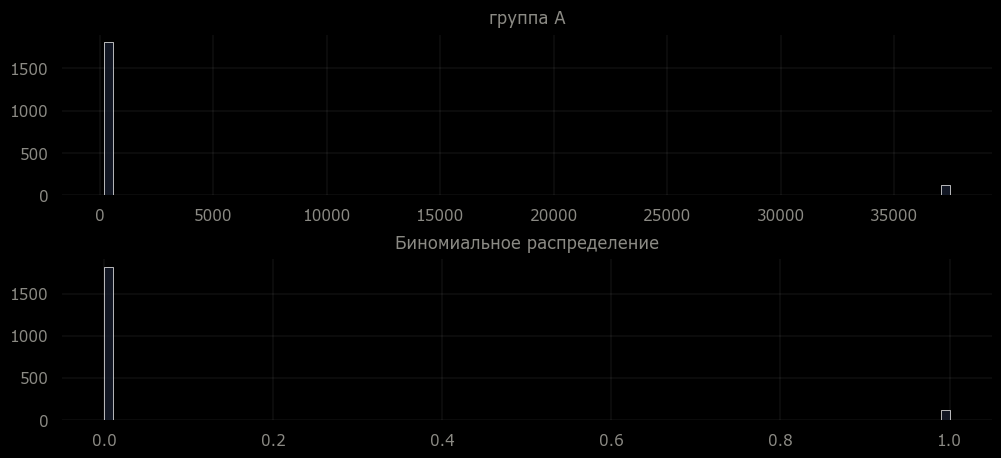

In [60]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=False)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('группа A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(np.random.binomial(1,123/(1805+123),1928), linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('Биномиальное распределение', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

In [26]:

b_example = np.random.binomial(1,123/(1805+123),1928)
df_bins = pd.DataFrame()
df_bins['a_bins'] = pd.cut(df_a[df_a.revenue > 0].revenue.values, 10).value_counts().values
df_bins['b_bins'] = pd.cut(b_example, 10).value_counts().values 
df_bins

,a_bins,b_bins
0,1805,1805
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,123,123


Прикольно, да? -)))

<Figure size 1300x600 with 0 Axes>

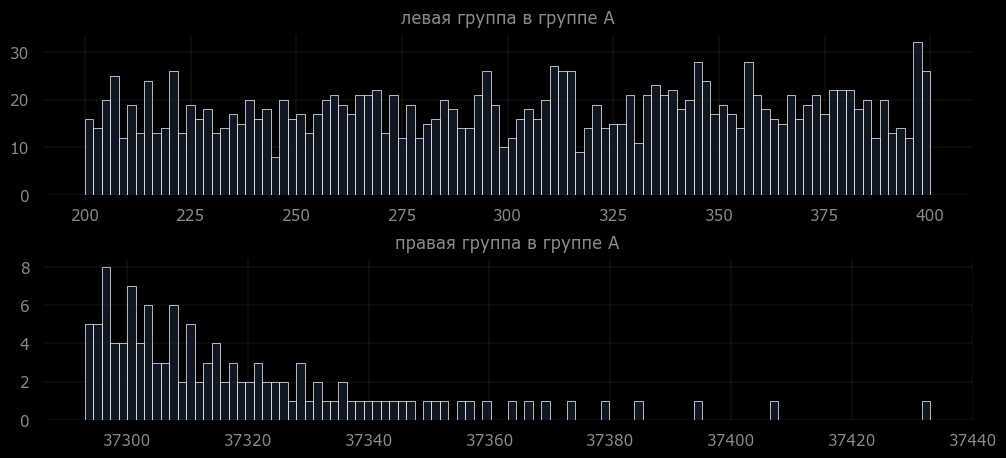

In [39]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=False)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[(df_a.revenue > 0)&(df_a.revenue < 20000)].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('левая группа в группе А', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_a[(df_a.revenue > 0)&(df_a.revenue > 20000)].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('правая группа в группе А', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()


То есть, биномиальное распределение в группе А определяет из распределения правой или левой части группы будет взято значение выборки. 

С этой точки зрения появление 123 дорогих заказов в определенной пропорции к дешевым можно легко объяснить, например так: каждый 10-й заказ получает суперскидку на дорогой товар (покупают со скидкой не все, поэтому доля дорогих заказов ниже 10%). 

Получается, что группа В  - равномерное распределение, группа А - имеет биномиальное распределение. При этом оба хорошо сходятся.

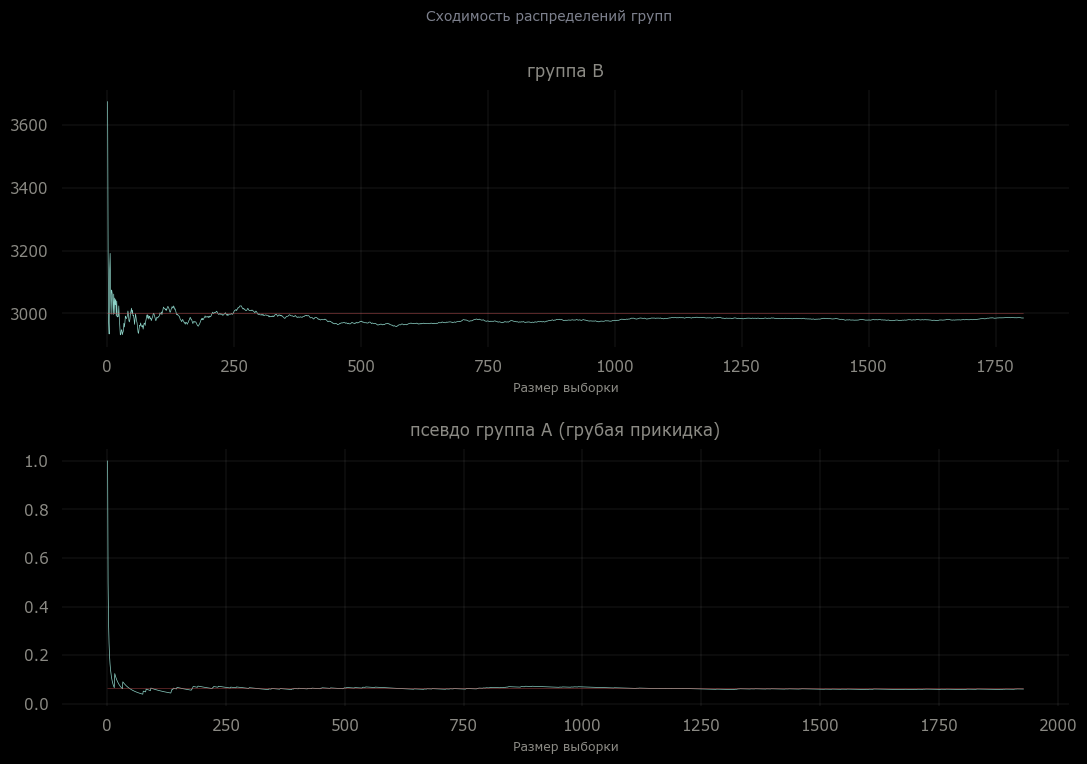

In [63]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)


plt.suptitle('Сходимость распределений групп', fontsize=10, color='#7d808d')

plt.subplot(2, 1, 1)
t1 = pd.Series(np.random.uniform(2000, 4000, 1805)).to_frame()
t1.columns=['res']
t1['csum']=t1['res'].cumsum()
t1['num']=range(1,1806)
t1['cmean']=t1.csum/t1.num

plt.plot(t1.num, t1.cmean, linewidth=0.5)
plt.plot(t1.num, np.array([3000]*1805), '-r',linewidth=0.3)
plt.title('группа В', fontsize=12, y=1.02, color='#8b8a84')
plt.xlabel("Размер выборки", labelpad = 5, fontsize= 9,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
t1 = pd.Series(np.random.binomial(1,123/(1805+123),1928)).to_frame()
t1.columns=['res']
t1['csum']=t1['res'].cumsum()
t1['csum'] = t1['csum']
t1['num']=range(1,1929)
t1['cmean']=t1.csum/t1.num
plt.plot(t1.num, t1.cmean, linewidth=0.5)
plt.plot(t1.num, np.array([t1.cmean.mean()]*1928), '-r',linewidth=0.3)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('псевдо группа А (грубая прикидка)', fontsize=12, y=1.02,color='#8b8a84')
plt.xlabel("Размер выборки", labelpad = 5, fontsize= 9,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Посмотрим как распределяются средние распределений с учетом размеров выборок

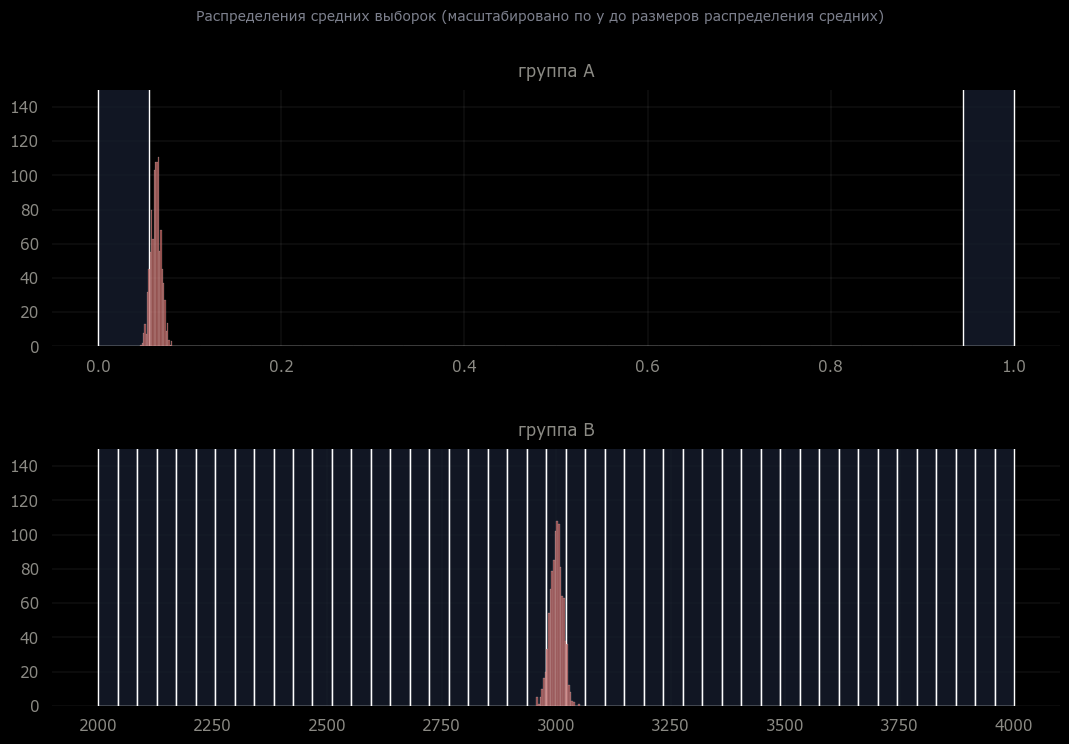

In [164]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.suptitle('Распределения средних выборок (масштабировано по y до размеров распределения средних)', fontsize=10, color='#7d808d')

plt.subplot(2, 1, 1)
t3 = np.random.binomial(1,123/(1805+123),100000)
t3_se = [pd.Series(t3).sample(1928).mean() for _ in range(1000)]
sns.histplot(t3, color='#171e2f')
sns.histplot(t3_se, color='#ba5a58')
plt.ylim(0, 150)
plt.title('группа А', fontsize=12, y=1.02, color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
t4 = np.random.uniform(2000, 4000, 100000)
t4_se = [pd.Series(t4).sample(1805).mean() for _ in range(1000)]
sns.histplot(t4, color='#171e2f')
sns.histplot(t4_se, color='#ba5a58')
plt.ylim(0, 150)
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.title('группа В', fontsize=12, y=1.02, color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Проверим нормальность распределений средних

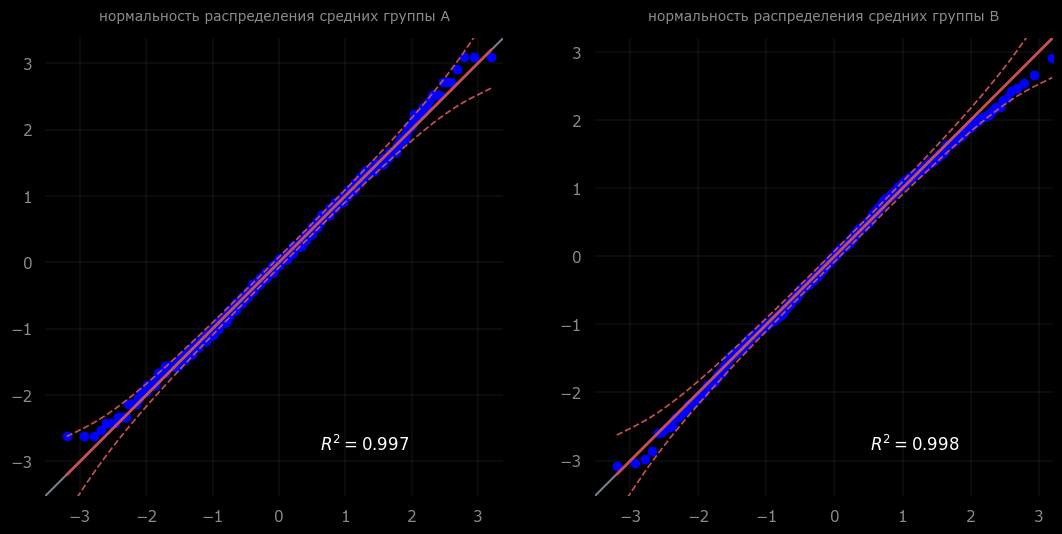

In [66]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(1, 2, 1)
pg.qqplot(t3_se)
plt.title('нормальность распределения средних группы А', fontsize=10, y=1.02, color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(1, 2, 2)
pg.qqplot(t4_se)
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.title('нормальность распределения средних группы В', fontsize=10, y=1.02, color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

С учетом размера выборок и нормальности распределения средних мы можем использовать t-test для определения статистической значимости разлиичий ARPPU групп А и В

In [84]:
pg.ttest(df_a[df_a.revenue > 0].revenue, df_b[df_b.revenue > 0].revenue)['p-val']


T-test    0.100208
Name: p-val, dtype: float64

При условии неравенства выборок в данном т-тесте автоматически применяется вариант т-теста Welch-а. P-value в 10% не позволяет нам отвергнуть нулевую гипотезу об отсутствии различия между ARPPU тестовой и контрольной групп. 

А значит наш вывод  на основе имеющихся данных: ARPPU в тестовой и контрольной группе статистически значимо не различается.

Теперь посмотрим на метрику CR  в покупку. Имеем следующие данные по группам.

In [141]:
df_cr = pd.DataFrame({'a' : [len(df_a[df_a.revenue > 0]), len(df_a) - len(df_a[df_a.revenue > 0])],\
                      'b' : [len(df_b[df_b.revenue > 0]), len(df_b) - len(df_b[df_b.revenue > 0])]},\
                       index = ['active', 'not_active'])

In [142]:
df_cr = df_cr.transpose().copy()
df_cr

,active,not_active
a,1928,200175
b,1805,200862


Нулевая гипотеза состоит в том, что CR в покупку (то есть отношение сделавших покупку к общему числу клиентов) статистически значимо не различается для тестовой и контрольной групп.

И поскольку CR является категориальной переменной - используем метод Хи-квадрат

In [151]:
print(f'p-value: {round(stats.chi2_contingency(df_cr)[1], 4)}')

p-value: 0.0365


Полученное значение p-value позволяет отклонить нулевую гипотезу и сделать вывод о том, что CR в покупку в тестовой и контрольной группе статистически значимо различаются.

In [157]:
print(f'CR контрольной группы А:   {round(len(df_a[df_a.revenue > 0])*100 / len(df_a), 2)}% \n\
CR тестовой группы В:      {round(len(df_b[df_b.revenue > 0]) *100/ len(df_b), 2)}%')

CR контрольной группы А:   0.95% 
CR тестовой группы В:      0.89%


Выводы: 

- Различия в ARPPU тестовой и контрольной групп не имеют статистической значимости
- CR в покупку контрольной группы выше чем тестовой и это различие статистически значимо

Делаем выбор в пользу контрольной группы.

--------------------

***В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?***

Уникальные предметы, внутриигровая валюта и подобные вещи интересны тем, кто уже регулярно играет. Для тех кто не играл раньше ценность бонусов не существует и не является стимулом для регистрации. Для игроков, которые играли раньше, но ушли из игры - ценность бонусов существет только в контексте какого-то иного стимула ("друг позвал в пати арканы полутать", "полгода не играл - зайду-ка гляну чо там вообще сейчас").

А значит retention старых полльзователей и число новых пользователей здесь не отражают ничего существенного. Тем более, что события ежемесячные и эффект привлечения новых пользователей скажется в основном через внешнюю рекламу события. Но это будет фактор рекламы, а не события как такового.

Событие направлено на тех, кто уже играет. Целей несколько:

1. Дух соперничества - подняться в социальной иерархии игровошго сообщества. 
2. Собрать внутриигровой клан, группу, гильдию для обмена опытом прохождения, совместного покорения вершин рейтинга события и таким образом привязаться к игре социально.
3. Налутать шмоток, которые психологически будут иметь для игрока ценность и удерживать его в от ухода из игры
4. Создать экономическое внутриигровое пространство - продажа шмоток, фарм шмоток на заказ, буст аккаунтов, тренерство и так далее. Так внутри игры одни игроки начут сами привязывать к игре других игроков
5. Повод похвастаться достижением в соцсетях и привлечь внимание к игре

Основные метрики:

1. Средняя длительность сессии - должна увеличиться
2. Среднее число сессий на пользователя в день - должно увеличиться
3. Retention игроков по когортам этапов события или конверсионное окно - должен падать в рамках статистических данных с предыдущих событий, игроки не должны бросать прохождение события
4. Retention игроков, начавших проходить событие по дням - должен падать в рамках статистических данных с предыдущих событий, игроки в целом должны пройти событие за отведенное время
5. Конверсия участия в событии в расшаривание своих достижения во вне
6. Retention игроков когорты участников события в последующие недели до следующего события - не должен падать сильное, события не должно изматывать, игроки не должны находиться в игре только во время события
7. Обычно в событиях есть бесплатный и мучительный путь, а так же платный и комфортный. Соответственно, метрика - среднее число покупок платного пути на пользователя ARPU ARPPU
8. Метрики оценки экономической эффективности события - ROI, ROMI, ROAS по событию





***Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?***

Если введение нового правила прохождения вызывает беспокойство (что справедливо), то, очевидно, следует наблюдать как игроки справляются с заданием и сохраняется ил у них восприятие события как челенджа и не замещается ли оно ассоциациями с онанизмом.

Основной контрольной метрикой здесь будет ежедневный retention по когортам непрошедших каждый уровень.